In [6]:
import random as rd
import sys
import copy
import pickle
import pathlib
import os

In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv1D, concatenate
from tensorflow.keras.layers import ZeroPadding1D, Reshape, Input, Dropout, PReLU
from tensorflow.keras.models import Sequential, Model
import code

In [11]:
data_dir   = pathlib.Path('/project/informatics_lab/data_science_cop/socrates_emulation/')
output_dir = pathlib.Path(os.environ['SCRATCH']) / 'ml_weather_tutorial'

if not output_dir.is_dir():
    output_dir.mkdir()
    print(f'creating directory {output_dir}')

## Define inputs
Specify the hyperparametersfor the pipeline and the locationof the input data

Set up the hyperparameters for out training

In [9]:
wl='sw'
target='nflx'
nsamps = '50.0K'
scale_data = True
if wl=='sw':
  model = 'sw_260'
  model_ref = 'sw_ga7'
elif wl=='lw':
  model = 'lw_300'
  model_ref = 'lw_ga7'


Construct the paths to file names that contain the data

In [12]:
fnext='train'
fn_meta = model+'_meta_'+nsamps+'_'+fnext+'.npz'
fn_dat_levs = model+'_dat_levs_'+nsamps+'_'+fnext+'.npz'
fn_dat_lays = model+'_dat_lays_'+nsamps+'_'+fnext+'.npz'
fn_dat_surf = model+'_dat_surf_'+nsamps+'_'+fnext+'.npz'
if target=='nflx':
  fn_trg = model+'_trg_levs_'+nsamps+'_'+fnext+'.npz'
if target=='ndiv':
  fn_trg = model+'_trg_lays_'+nsamps+'_'+fnext+'.npz'
 
fnext='test'
fn_meta_test = model+'_meta_'+nsamps+'_'+fnext+'.npz'
fn_dat_levs_test = model+'_dat_levs_'+nsamps+'_'+fnext+'.npz'
fn_dat_lays_test = model+'_dat_lays_'+nsamps+'_'+fnext+'.npz'
fn_dat_surf_test = model+'_dat_surf_'+nsamps+'_'+fnext+'.npz'
if target=='nflx':
  fn_trg_test = model+'_trg_levs_'+nsamps+'_'+fnext+'.npz'
  fn_trg_ref = model_ref+'_trg_levs_'+nsamps+'_'+fnext+'.npz'
if target=='ndiv':
  fn_trg_test = model+'_trg_lays_'+nsamps+'_'+fnext+'.npz'
  fn_trg_ref = model_ref+'_trg_lays_'+nsamps+'_'+fnext+'.npz'

print('root dir:',data_dir)

root dir: /project/informatics_lab/data_science_cop/socrates_emulation


### Loading and preparing the  training data

In [15]:
print('loading',fn_dat_lays)
with np.load(data_dir / fn_dat_lays) as npzfile:
    dat_lays = npzfile['dat_lays']

loading sw_260_dat_lays_50.0K_train.npz


In [18]:
print('loading',fn_dat_surf)
with np.load(data_dir / fn_dat_surf) as npzfile:
    dat_surf = npzfile['dat_surf']

loading sw_260_dat_surf_50.0K_train.npz


In [16]:
print('loading',fn_trg)
with np.load(data_dir / fn_trg) as npzfile:
    if target=='nflx':
         trg = npzfile['trg_levs']
    elif target=='ndiv':
         trg = npzfile['trg_lays']

loading sw_260_trg_levs_50.0K_train.npz


In [19]:
nsamps = trg.shape[0]
nlays = dat_lays.shape[1]
nlay_feats = dat_lays.shape[2]
nsurf_feats = dat_surf.shape[1]

Next we normalise the data

In [59]:
dat_lays

array([[[7.48596189e-02, 2.07117128e-02, 1.28316524e-02, ...,
         0.00000000e+00, 9.53195985e-02, 0.00000000e+00],
        [7.50777509e-02, 2.07628967e-02, 1.28662172e-02, ...,
         0.00000000e+00, 2.39585537e-01, 0.00000000e+00],
        [7.52075666e-02, 2.07914892e-02, 1.28858323e-02, ...,
         0.00000000e+00, 3.97299512e-01, 0.00000000e+00],
        ...,
        [2.59644903e-03, 9.05737910e-04, 3.99721354e-03, ...,
         7.23902259e-01, 9.38158696e-01, 0.00000000e+00],
        [1.61318348e-03, 5.63421798e-04, 2.31647339e-03, ...,
         7.23902259e-01, 9.41771698e-01, 0.00000000e+00],
        [5.87507001e-04, 2.05322775e-04, 5.60418666e-04, ...,
         7.23902259e-01, 9.44402078e-01, 0.00000000e+00]],

       [[1.26202793e-04, 3.66322592e-06, 1.57547697e-03, ...,
         0.00000000e+00, 4.29455379e-02, 0.00000000e+00],
        [1.28851030e-04, 3.75739613e-06, 1.57675368e-03, ...,
         0.00000000e+00, 1.72811216e-01, 0.00000000e+00],
        [1.42091854e-04, 

In [29]:
dat_lays.shape

(50000, 70, 29)

In [20]:
if scale_data: # normalize by range
  scaler_lays = []
  use_lays = []
  for ic in range(nlay_feats):
    min0 = np.min(dat_lays[:,:,ic])
    range0 = np.max(dat_lays[:,:,ic]) - min0
    if range0 > 0.:
      dat_lays[:,:,ic] = (dat_lays[:,:,ic] - min0)/range0
      scaler_lays.append([min0, range0])
      use_lays.append(ic)
  if len(use_lays)<nlay_feats:
    print('removing constant layer features:', nlay_feats-len(use_lays))
    dat_lays = dat_lays[:,:,use_lays]
    nlay_feats = len(use_lays)
      

  scaler_surf = []
  use_surf = []
  for ic in range(nsurf_feats):
    min0 = np.min(dat_surf[:,ic])
    range0 = np.max(dat_surf[:,ic]) - min0
    if range0 > 0.:
      dat_surf[:,ic] = (dat_surf[:,ic] - min0)/range0
      scaler_surf.append([min0, range0])
      use_surf.append(ic)
  if len(use_surf)<nsurf_feats:
    print('removing constant surf features:', nsurf_feats-len(use_surf))
    dat_surf = dat_surf[:,:,use_surf]
    nsurf_feats = len(use_surf)



removing constant layer features: 6


In [23]:
ntrg_samps = trg.shape[0]

if target=='nflx' or target=='ndiv':
  nouts=1
  ntrg_levs = trg.shape[1]


In [39]:
def build_model_mlp(nlays, nlay_feats):
    profile_input = Input(shape=(nlays, nlay_feats), name='profile_input')
    surf_input = Input(shape=(nsurf_feats,), name='surf_input')
    flat_profs = Flatten()(profile_input)
    raw_in = tf.keras.layers.concatenate([flat_profs, surf_input])
    raw_size = (nlays*nlay_feats)+nsurf_feats
    prof_size = nlays*nlay_feats

    x = Dense(512, use_bias=False, activation='relu')(raw_in)
    x = Dense(512, use_bias=False, activation='relu')(x)
    x = Dense(256, use_bias=False, activation='relu')(x)
    x = Dense(256, use_bias=False, activation='relu')(x)
    x = Dense(128, use_bias=False, activation='relu')(x)
    x = Dense(128, use_bias=False, activation='relu')(x)

    main_output = Dense(ntrg_levs, use_bias=True, activation='linear', name='main_output')(x)
    model = Model(inputs=[profile_input, surf_input], outputs=[main_output])
    return model

In [40]:
def build_model_cnn(nlays, nlay_feats):
    profile_input = Input(shape=(nlays, nlay_feats), name='profile_input')
    surf_input = Input(shape=(nsurf_feats,), name='surf_input')
    flat_profs = Flatten()(profile_input)
    raw_in = tf.keras.layers.concatenate([flat_profs, surf_input])
    raw_size = (nlays*nlay_feats)+nsurf_feats
    prof_size = nlays*nlay_feats

    out = ZeroPadding1D(padding=1)(profile_input)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    ident = out
    out = ZeroPadding1D(padding=1)(out)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    out = ZeroPadding1D(padding=1)(out)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    x = tf.keras.layers.add([out, ident])
    out = Flatten()(x)
    out = Dense(prof_size, use_bias=False, activation='relu')(out)

    out = tf.keras.layers.concatenate([out, surf_input])
    x = tf.keras.layers.add([out, raw_in])
    x = Dense(1024, use_bias=False, activation='relu')(x)
    x = Dense(1024, use_bias=False, activation='relu')(x)

    main_output = Dense(ntrg_levs, use_bias=True, activation='linear', name='main_output')(x)
    model = Model(inputs=[profile_input, surf_input], outputs=[main_output])
    return model

In [41]:
model_dict = {'mlp': {'build_func': build_model_mlp,},
              'cnn_1d': {'build_func': build_model_cnn,},
             }

In [42]:
%%time
for model_name in model_dict.keys():
    print(f'building and training model {model_name}')
    model_dict[model_name]['model_object'] = model_dict[model_name]['build_func'](nlays=nlays, nlay_feats=nlay_feats)
    model_dict[model_name]['model_object'].compile(loss='mean_absolute_error',
                                                   optimizer='adam')
    model_dict[model_name]['model_object'].fit([dat_lays, dat_surf], trg, epochs=1, batch_size=32, verbose=0)

building and training model mlp


2022-07-08 15:56:53.774845: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


building and training model cnn_1d
CPU times: user 4min 19s, sys: 28.9 s, total: 4min 48s
Wall time: 52.6 s


In [ ]:
del dat_lays, dat_surf


### Testing the output

Next we load in the test data and do inferenceto check the result

In [44]:
print('loading',fn_dat_lays_test)
with np.load(data_dir / fn_dat_lays_test) as npzfile:
    dat_lays_test = npzfile['dat_lays']

print('loading',fn_dat_surf_test)
with np.load(data_dir / fn_dat_surf_test) as npzfile:
    dat_surf_test = npzfile['dat_surf']

print('loading',fn_trg_test)
with np.load(data_dir / fn_trg_test)as npzfile:
    if target=='nflx':
        trg_test = npzfile['trg_levs']
    elif target=='ndiv':
         trg_test = npzfile['trg_lays']

print('loading',fn_trg_ref)
with np.load(data_dir / fn_trg_ref) as npzfile:
    if target=='nflx':
         trg_ref = npzfile['trg_levs_ref']
    elif target=='ndiv':
         trg_ref = npzfile['trg_lays_ref']

loading sw_260_dat_lays_50.0K_test.npz
loading sw_260_dat_surf_50.0K_test.npz
loading sw_260_trg_levs_50.0K_test.npz
loading sw_ga7_trg_levs_50.0K_test.npz


In [45]:
# scale test data
if scale_data: # normalize by range
  dat_lays_test = dat_lays_test[:,:,use_lays]
  for ic in range(nlay_feats):
    dat_lays_test[:,:,ic] = (dat_lays_test[:,:,ic] - scaler_lays[ic][0])/scaler_lays[ic][1]

  dat_surf_test = dat_surf_test[:,use_surf]
  for ic in range(nsurf_feats):
    dat_surf_test[:,ic] = (dat_surf_test[:,ic] - scaler_surf[ic][0])/scaler_surf[ic][1]



### Do inference on test data

In [50]:
predictions = {}

In [51]:
for model_name, selected_model in model_dict.items():
  predictions[model_name] = selected_model['model_object'].predict([dat_lays_test, dat_surf_test])

### Calaculate metrics for test data

In [52]:
metrics_dict = {}
for model_name in model_dict.keys():
    metrics_dict['me_p'] = np.zeros(ntrg_levs)
    metrics_dict['me_ctl'] = np.zeros(ntrg_levs)
    metrics_dict['mae_p'] = np.zeros(ntrg_levs)
    metrics_dict['mae_ctl'] = np.zeros(ntrg_levs)
    for ilev in range(ntrg_levs):
      metrics_dict['me_p'][ilev] = np.mean(predictions[model_name][:,ilev] - trg_test[:,ilev])
      metrics_dict['me_ctl'][ilev] = np.mean(trg_ref[:,ilev] - trg_test[:,ilev])
      metrics_dict['mae_p'][ilev] = np.mean(np.abs(predictions[model_name][:,ilev] - trg_test[:,ilev]))
      metrics_dict['mae_ctl'][ilev] = np.mean(np.abs(trg_ref[:,ilev] - trg_test[:,ilev]))    

### Visualise metrics

In [53]:
yax = np.arange(1,len(me_p[1:])+1)[::-1]


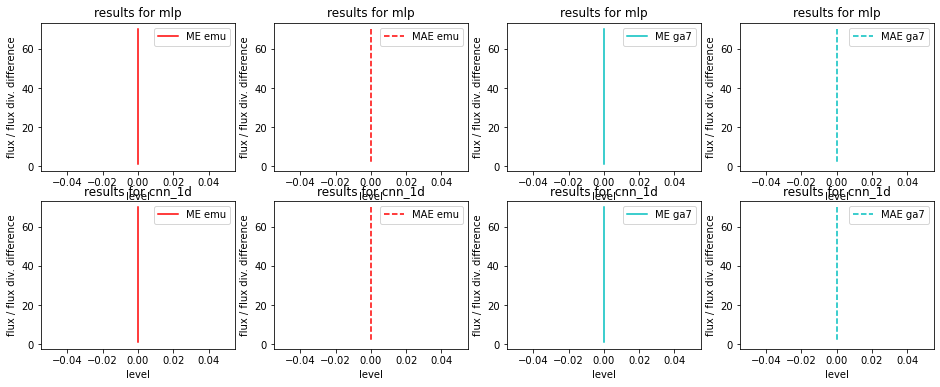

In [58]:
fig1 = plt.figure('compare_NN_results', figsize=(16,6))
for ix1,model_name in enumerate(model_dict.keys()):
    ax1 = fig1.add_subplot(2,4,(4*ix1) + 1,title=f'results for {model_name}')
    ax1.plot(me_p[1:],yax, '-r', label='ME emu')
    ax1.set_xlabel('level')
    ax1.set_ylabel('flux / flux div. difference')
    ax1.legend(loc='upper right')
  
    ax1 = fig1.add_subplot(2,4,(4*ix1) + 2, title=f'results for {model_name}')
    ax1.plot(mae_p[1:],yax, '--r', label='MAE emu')
    ax1.set_xlabel('level')
    ax1.set_ylabel('flux / flux div. difference')
    ax1.legend(loc='upper right')
    
    ax1 = fig1.add_subplot(2,4, (4*ix1) + 3, title=f'results for {model_name}')
    plt.plot(me_ctl[1:],yax, '-c', label='ME ga7')
    ax1.set_xlabel('level')
    ax1.set_ylabel('flux / flux div. difference')
    ax1.legend(loc='upper right')
    
    ax1 = fig1.add_subplot(2,4, (4*ix1) + 4, title=f'results for {model_name}')
    ax1.plot(mae_ctl[1:],yax, '--c', label='MAE ga7')
    ax1.set_xlabel('level')
    ax1.set_ylabel('flux / flux div. difference')
    ax1.legend(loc='upper right')
    
